In [34]:
# Initialize Otter
import otter
grader = otter.Notebook("hw08.ipynb")

<a id="top"></a>

# Homework 8: Snow (continued) + IMDb
## `xarray` + SQL
## Due Date: Thursday, November 10, 11:59 PM PDT

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*



## Introduction

This homework has two disjoint parts:

**Part 1:** We will continue our explorations of worldwide snow cover from Lab 9 using the `xarray` package, uncovering interesting trends in snow density over time. [Click here to jump to Part 1](#part-1)

**Part 2:** We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings. [Click here to jump to Part 2](#part-2).

## Grading 

Grading is broken down into autograded answers and free response. For autograded answers, the results of your code are compared to provided and/or hidden tests. For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

<!--
<details>
    <summary>[Click to Expand] <b>Scoring Breakdown</b></summary>-->
|Question|Points|
|---|---|
|Q1 | 1 |
|Q2 | 1 |
|Q3 | 3 |
|Q4a | 2 |
|Q4b | 2 |
|Q5 | 3 |
|Q6 | 3 |
|Q7 | 4 |
|Q8 | 4 |
|Total | 23 |
</details>

In [35]:
# Run this cell to set up your notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xarray as xr
import sqlalchemy
from pathlib import Path

#Comment out this line after you have run it
!pip install ipython-sql


plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

---
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

---

<a id='part-1'></a>
# Part 1: ERA5 Snow Cover (continued)

(Click [here](#top) to jump back to the top of this notebook.)

In this part of the homework, we will be continuing to explore worldwide snow accumulation trends from the ERA5 dataset from Lab 9. More specifically, we wish to look at the yearly minimum and maximum snow accumulation levels, and see if there are any interesting trends. Like in the lab, you will be using `xarray` to accomplish this part's tasks. The `xarray` [documentation](https://docs.xarray.dev/en/stable/) will be very helpful for this part of the assignment.

Before getting into the tasks, we will first overview what you did in Lab 9.

In [36]:
# run this cell
DATA_DIR = Path('./data')
monthly_2deg_path = DATA_DIR / "era5_snow_monthly_2deg_aws_v20210920.nc"
ds = xr.open_dataset(monthly_2deg_path)

First, let's look at the output of this `xarray.Dataset` object

In [37]:
ds

<xarray.Dataset>
Dimensions:       (time: 504, latitude: 90, longitude: 180)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11...
  * latitude      (latitude) float32 -88.88 -86.88 -84.88 ... 85.12 87.12 89.12
  * longitude     (longitude) float32 0.875 2.875 4.875 ... 354.9 356.9 358.9
Data variables:
    snow_density  (time, latitude, longitude) float32 ...

Recall that an `xarray.Dataset` can be thought of as a generalization of a `pandas.DataFrame` that is especially suited for working with physical data. Physical datasets often consist of data collected at points at particular locations on Earth at particular times. We can think of this data as being indexed by three-dimensions: longitude, latitude, and time. Pandas DataFrames only have one-dimensional indexing (observations are only indexed by row numbers), making this data structure a bit cumbersome to work with in such applied contexts. An `xarray.Dataset` consists of `xarray.DataArray` objects, one for each measurement variable of interest (in the above `xarray.Dataset` object, there is only one measurement variable). An `xarray.DataArray` object contains such measurements indexed at locations in time and space. Thus, given an `xarray.DataArray` object containing snow density measurements, for instance, users can analyze snow density measurements at particular locations on Earth at particular times by providing inputting locations and times as opposed to querying rows of a DataFrame.

In our variable `ds`, we have an `xarray.Dataset` object with one `xarray.DataArray` object, consisting of `snow_density` measurements across time and location. The following cell extracts the `xarray.DataArray` object consisting of snow density measurements, similar to extracting a column from a `Pandas.DataFrame`.

In [38]:
snow = ds.snow_density
snow

<xarray.DataArray 'snow_density' (time: 504, latitude: 90, longitude: 180)>
[8164800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11:30:00
  * latitude   (latitude) float32 -88.88 -86.88 -84.88 ... 85.12 87.12 89.12
  * longitude  (longitude) float32 0.875 2.875 4.875 6.875 ... 354.9 356.9 358.9
Attributes:
    long_name:       Snow density
    nameCDM:         Snow_density_surface
    nameECMWF:       Snow density
    product_type:    analysis
    shortNameECMWF:  rsn
    standard_name:   snow_density
    units:           kg m**-3

Recall `xarray` is also nice in that, if we wanted to average our snow density measurements across all time and plot the aggregate values by spatial location, we can do this in two lines of code.

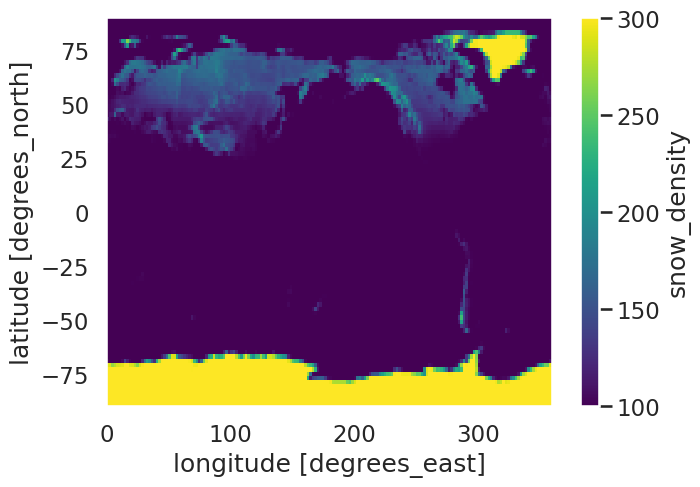

In [39]:
# run this cell
mean_map = ds.mean("time")  # takes the mean across all variables in ds
mean_map.snow_density.plot(); # extract snow_density DataArray, then plot

In **Question 4** of Lab 9, you were asked to make two figures showing the spatial distribution of snow density measurements for both February 1980 (Northern Hemisphere winter) and August 1980 (Southern Hemisphere summer). This could be done using the code in the following two cells:

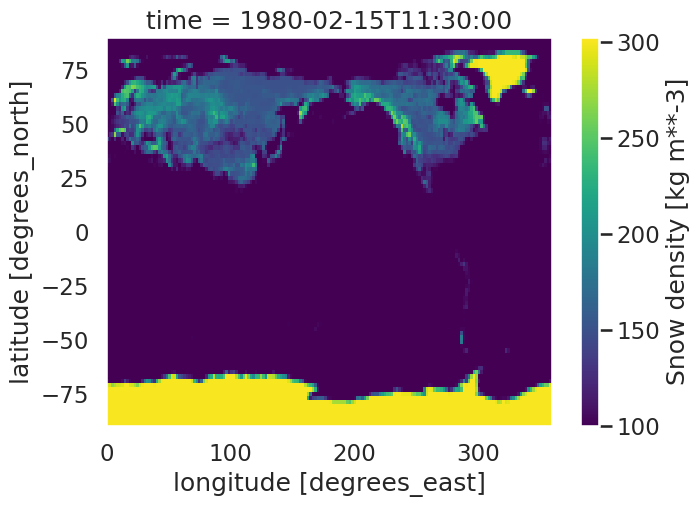

In [40]:
snow.sel(time='1980-02').plot();

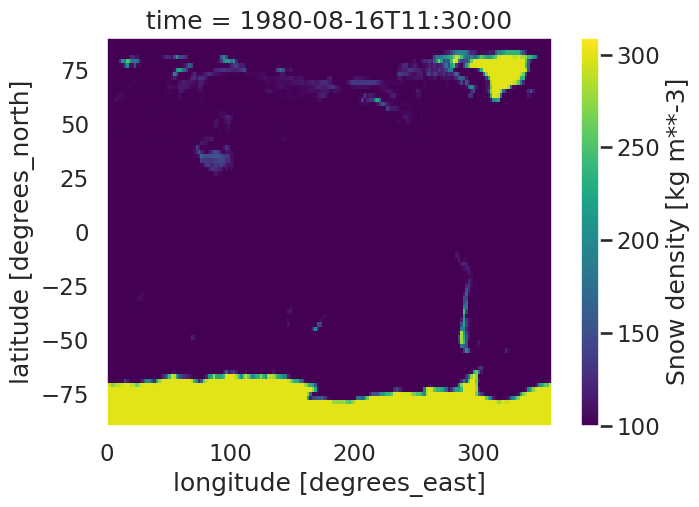

In [41]:
snow.sel(time='1980-08').plot();

Notice how these plots make a lot of sense: snow cover is higher in the Northern hemisphere during winter time, and when summer comes around, that snow melts. However, at the same time, winter arrives in the Southern hemisphere, and so snow appears on mountains in South America and New Zealand.

This is where Lab 9 left off. Now, let's continue analyzing the data, with the ultimate goal of understanding and displaying trends of snow accumulation over the years using `xarray`.

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1

In both the northern and southern hemispheres, make lineplots showing the average snow density (averaged across all locations in the respective hemisphere) on the y-axis and the date/time on the x-axis. To make answering Question 3 easier, also create `xarray.DataArray` objects containing this spatially-aggregated data, one for each hemisphere.

<!-- BEGIN QUESTION -->



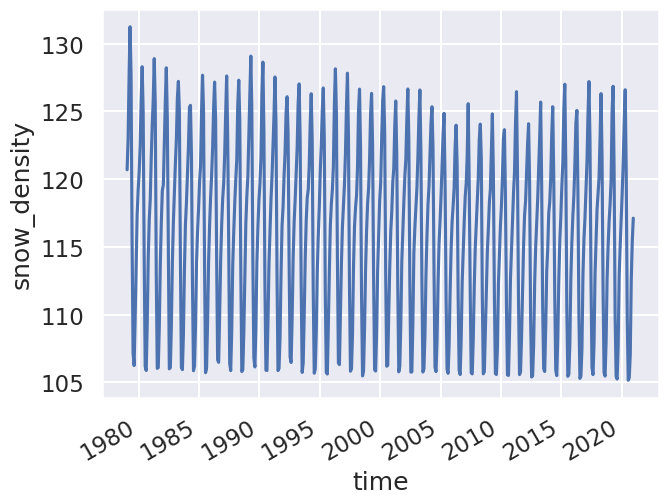

In [42]:
t_snow_north = ds.loc[dict(latitude=slice(0,90))].snow_density.mean('latitude').mean('longitude')
t_snow_north.plot();

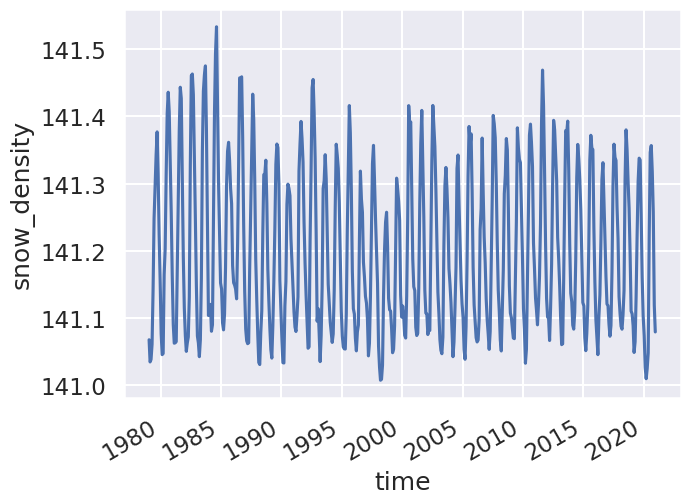

In [43]:
t_snow_south = ds.loc[dict(latitude=slice(-90,0))].snow_density.mean('latitude').mean('longitude')
t_snow_south.plot();

<!-- END QUESTION -->

## Question 2

<!-- BEGIN QUESTION -->

For each hemisphere, we observe clear cycles in average snow accumulation over time, which makes sense because of seasonal temperature changes. However, the plots above are a little bit busy. For this question, make a similar plot, *but only show average snow density measurements for the northern hemisphere in the year 1979*. 


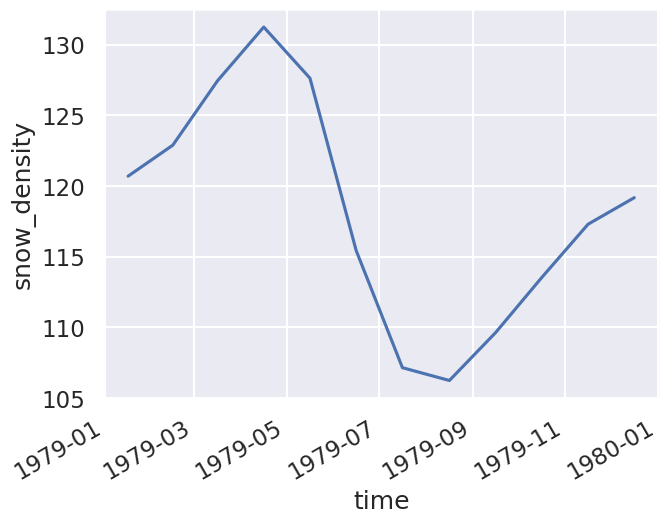

In [44]:
t_snow_north_1979 = ds.loc[dict(latitude=slice(0,90))].snow_density.mean('latitude').mean('longitude').sel(time="1979")
t_snow_north_1979.plot();

<!-- END QUESTION -->

## Question 3 

Now that we have a sense of seasonal and yearly change in snow accumulation in both hemispheres, let's work to use `xarray` to extract yearly maxima and minima and get a sense of how these levels are changing over time.

For this question, you will need to fill in the `extract_peaks` function such that, if you plugged in an `xarray.DataArray` containing average snow density measurements for each hemisphere over time (like the ones you made in Question 1), you'd return a `pandas.DataFrame` that looks like the following:

<img src="snow-peaks-north-df.png" width="900px" />


When filling out the `extract_peaks` function, think about what information we want your DataFrame to contain, what information your `xarray.DataArray` objects contain already, and how you might write code to get the desired output.

Some hints:

1. First, we want to extract the years from the data and iterate over them using `range`
2. When iterating over the years, for each year, extract the maximum and minimum snow accumulation measurements, as well as the day of year and dates that those measurements occured on. Amplitude is computed by taking the difference between a year's max and min snow accumulation levels, and all of this information will be stored in an array called `vals`.
3. `peaks` should be an array consisting of all of the information in `vals`, plus any other columns we ask for in the above printout that is not already in `vals`.
4. The `DataArray.idxmin` and `DataArray.idxmax` methods may be useful.
5. If you have a `DataArray` called `x` containing single value (day of year where min snowfall happened in a single year, for example), and you'd rather extract that value from as an int/string/date etc., use `x.values.item`.


In [45]:
t_snow_north.time

<xarray.DataArray 'time' (time: 504)>
array(['1979-01-16T11:30:00.000000000', '1979-02-14T23:30:00.000000000',
       '1979-03-16T11:30:00.000000000', ..., '2020-10-16T11:30:00.000000000',
       '2020-11-15T23:30:00.000000000', '2020-12-16T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11:30:00

In [46]:
def extract_peaks(snow_data):
    ...
    years = range(snow_data)
    peaks = []
    for y in years:
    ...
        vals = ...
    ...

    snow_peaks = pd.DataFrame(peaks, 
                              columns = ['year', 'min_date', 'max_date',
                                         'min_dayofyear', 'max_dayofyear',
                                         'min_snow', 'max_snow', 'amplitude'])

    return snow_peaks

peaks_north = extract_peaks(t_snow_north)
peaks_north.head()

IndentationError: expected an indented block (993699059.py, line 6)

With this DataFrame, we can now quickly explore several questions. For example, during what day of the year do the min and max happen?

In [ ]:
# run this cell
plt.plot('year', 'min_dayofyear', data=peaks_north);
plt.plot('year', 'max_dayofyear', data=peaks_north);
plt.legend();

What is the min and max amount of snow at those times?

In [ ]:
# run this cell
plt.plot('year', 'min_snow', data=peaks_north);
plt.plot('year', 'max_snow', data=peaks_north);
plt.legend();

Given the difference in scales, it's a bit easier to see what is happening if we plot the min and max separately:

In [ ]:
# run this cell
plt.plot('year', 'min_snow', data=peaks_north);
plt.plot('year', 'min_snow', 'r.', data=peaks_north);
plt.legend();

In [ ]:
# run this cell
plt.plot('year', 'max_snow', data=peaks_north);
plt.plot('year', 'max_snow', 'r.', data=peaks_north);
plt.legend();

<br/><br/>

---
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

---

<a id='part-1'></a>
# Part 2: The IMDB (mini) Dataset


(Click [here](#top) to jump back to the top of this notebook.)

We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab. The remainder of this overview section is copied from this week's lab.

Let's load in the database in two ways (using both Python and cell magic) so that we can flexibly explore the SQL database.

A few reminders: 
* **Only SQL code written with `pd.read_sql` will be graded.**  You should feel free to create `%%sql` cells **after** your Python answer + autograder cells to reduce debugging headaches, but you will still need to copy over any SQL to the Python answer cells. **Do not** add new cells betwen the question and the grading cells; it will cause errors when we run the autograder, and it will sometimes cause an error in generating the PDF file.

* **Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. **Use the LIMIT keyword** to avoid printing out 100k-sized tables (but remember to remove it).

* Films and movies are equivalent ways of expressing the condition that `titleType = 'movie'`, and they are used interchangeably throughout the assignment. They refer to the same thing!

In [47]:
# run this cell and the next one
engine = sqlalchemy.create_engine("sqlite:///data/imdbmini.db")
connection = engine.connect()

In [48]:
%sql sqlite:///data/imdbmini.db

<br/>

Let's take a look at the table schemas:

In [49]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///data/imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 4

### Question 4a
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 

List the **10 oldest `movie` titles** by `startYear` and then `primaryTitle` both in **ascending** order.  Do not include films where the `startYear` is `NULL`.  The output should contain the `startYear`, `primaryTitle`, and `titleType`.

Remember, you can create a `%%sql` cell **after** the grader cell as scratch work. Just be sure to copy the query back into the Python cell to run the autograder.


In [50]:
query_q4a = """
SELECT startYear, primaryTitle, titleType
FROM Title
WHERE startYear IS NOT NULL
ORDER BY startYear, primaryTitle
LIMIT 10;
"""


res_q4a = pd.read_sql(query_q4a, engine)
res_q4a

,startYear,primaryTitle,titleType
0,1902,A Trip to the Moon,short
1,1915,The Birth of a Nation,movie
2,1920,The Cabinet of Dr. Caligari,movie
3,1921,The Kid,movie
4,1922,Nosferatu,movie
5,1924,Sherlock Jr.,movie
6,1925,Battleship Potemkin,movie
7,1925,The Gold Rush,movie
8,1926,The General,movie
9,1927,Metropolis,movie


In [51]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 4b

Next, let's calculate the distribution of films by year. Write a query that returns the **total** `movie` titles for each `startYear` in the `Title` table as `total`.  Keep in mind that some entries may not have a `startYear` listed -- you should filter those out.  Order your final results by the `startYear` in **ascending** order.

The first few records of the table should look like the following (but you should compute the entire table).


| |startYear|total|
|-----|------|-----|
|**0**|1915|1|
|**1**|1920|1|
|**2**|1921|1|
|**3**|1922|1|
|...|...|...|



In [52]:
query_q4b = """
SELECT startYear, COUNT(*) as total
FROM Title
WHERE startYear IS NOT NULL 
AND titleType='movie'
GROUP BY startYear
ORDER BY startYear;
"""


res_q4b = pd.read_sql(query_q4b, engine)
res_q4b

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


In [53]:
grader.check("q4b")

q4b results: All test cases passed!

<br/>

The following should generate an interesting plot of the number of films that premiered each year. Notice there is a dip between the 1920s and late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

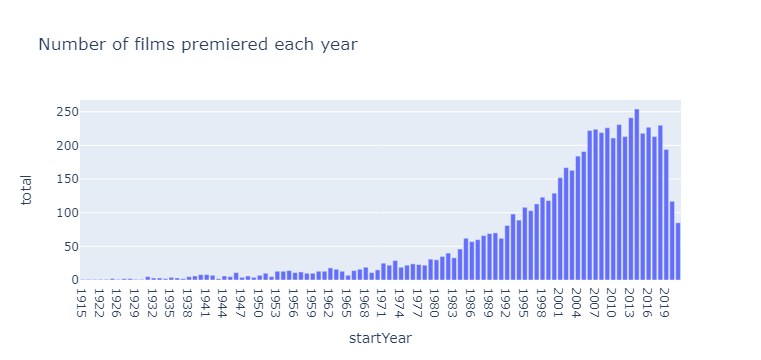

In [54]:
# just run this cell
px.bar(res_q4b, x="startYear", y="total",
       title="Number of films premiered each year")

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 5

Who are the **top 10 most prolific movie actors**?

Define the term "movie actor" is defined as anyone with an `actor` or `actress` job category role in a `movie` title.

Your SQL query should output exactly two fields named `name` (the movie actor name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in descending order, and break ties by ordering by `name` in ascending order.

Your result should look something like the following, but without `????`:

| | name | total |
|-----|-----|-----|
|**0**| ???? | 64 |
|**1**| ???? | 54 |
|**2**| ???? | 53 |
|**3**| ???? | 49 |
|**4**| ???? | 46 |
|**5**| ???? | 43 |
|**6**| ???? | 41 |
|**7**| ???? | 40 |
|**8**| ???? | 40 |
|**9**| ???? | 39 |

Some hints: 

* ***The query should take < 2 minutes to run.***
* Google the top of the list and see if it makes sense.
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.
<!--* You can assume each movie actor only has one role per film. If you're not sure how this hint affects your query, ignore this hint.-->


In [55]:
query_q5 = """
SELECT primaryName AS name, COUNT(*) AS total
FROM Name
JOIN Role
ON Name.nconst=Role.nconst
JOIN Title
On Role.tconst=Title.tconst
WHERE (category='actor' OR category='actress')
AND titleType='movie'
GROUP BY name
ORDER BY total DESC
LIMIT 10;
"""


res_q5 = pd.read_sql(query_q5, engine)
res_q5

,name,total
0,Robert De Niro,64
1,Samuel L. Jackson,54
2,Nicolas Cage,53
3,Bruce Willis,49
4,Tom Hanks,46
5,Johnny Depp,43
6,Mark Wahlberg,41
7,Morgan Freeman,40
8,Liam Neeson,40
9,Sylvester Stallone,39


In [56]:
grader.check("q5")

q5 results: All test cases passed!

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 6: The `CASE` Keyword

The `Rating` table has the `numVotes` and the `averageRating` for each title. Which `movie` titles were **"big hits"**, defined as a movie with over 100,000 votes? Construct the following table:

| | isBigHit | total |
|-----|-----|-----|
|**0**| no | ???? |
|**1**| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

* Rating.numVotes currently consists of string objects, use `CAST(Rating.numVotes AS int)` to convert them to integer.
* You will need to use  some type of `JOIN`.
* You may also consider using a `CASE WHEN ... IS ... THEN 'yes' ... ELSE ... END` statement. `CASE` statements are the SQL-equivalent of Python `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp


In [57]:
query_q6 = """
SELECT CASE WHEN CAST(numVotes AS int) > 100000 THEN 'yes' ELSE 'no' END AS isBigHit, COUNT(*) AS total
FROM Rating
JOIN Title
ON Rating.tconst=Title.tconst
WHERE titleType='movie'
GROUP BY isBigHit;
"""


res_q6 = pd.read_sql(query_q6, engine)
res_q6

,isBigHit,total
0,no,4318
1,yes,2041


In [58]:
grader.check("q6")

q6 results: All test cases passed!

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 7

**How does film length relate to ratings?**  To answer this question we want to bin `movie` titles by length and compute the average of the average ratings within each length bin. We will group movies by 10-minute increments -- that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on. Use the following code snippet to help construct 10-minute bins: 

```
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin
```

Construct a table containing the **`runtimeBin`**, the **average** of the **average ratings** (as `averageRating`), the **average number of votes** (as `averageNumVotes`), and the number of `titles` in that **runtimeBin** (as `total`).  Only include movies with **at least 10000 votes**.  Order the final results by the value of `runtimeBin`.


In [59]:
query_q7 = """
SELECT ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin, AVG(averageRating) AS averageRating, AVG(numVotes) AS averageNumVotes, COUNT(*) AS total
FROM Title
JOIN Rating
ON Title.tconst = Rating.tconst
WHERE titleType='movie' AND numVotes>10000
GROUP BY runtimeBin
ORDER BY runtimeBin;
"""


res_q7 = pd.read_sql(query_q7, engine)
res_q7.head()

,runtimeBin,averageRating,averageNumVotes,total
0,50.0,7.850000,42535.000000,2
1,60.0,6.400000,30668.500000,2
2,70.0,7.600000,59822.000000,13
3,80.0,6.860937,67896.187500,64
4,90.0,6.283951,76907.608466,567


In [60]:
grader.check("q7")

q7 results: All test cases passed!

<br/>

If your SQL query is correct you should get some interesting plots below.  This might explain why directors keep going a particular direction with film lengths.  

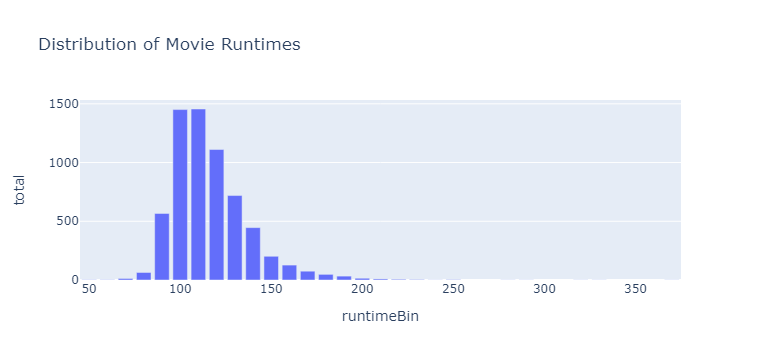

In [61]:
# just run this cell
px.bar(res_q7, x="runtimeBin", y="total",
       title="Distribution of Movie Runtimes")

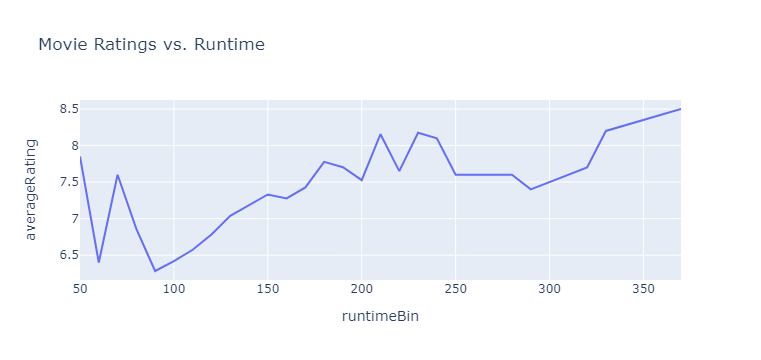

In [62]:
# just run this cell
px.line(res_q7, x="runtimeBin", y="averageRating",
        title="Movie Ratings vs. Runtime")

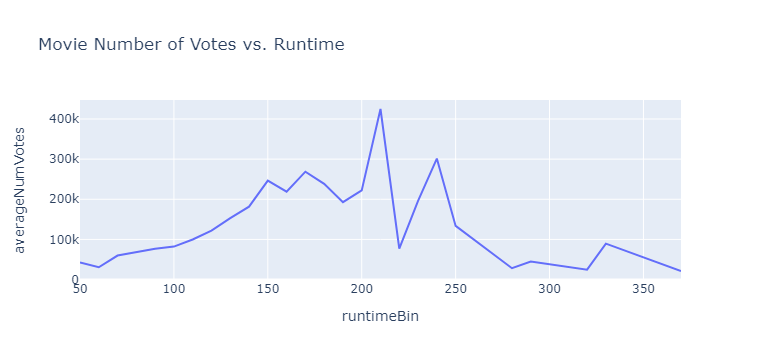

In [63]:
px.line(res_q7, x="runtimeBin", y="averageNumVotes",
        title="Movie Number of Votes vs. Runtime")

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 8


Which **movie actors** have the highest average ratings across all the **movies** in which they star? Again, define "movie actor" as anyone with an `actor` or `actress` job category role in a `movie` title.

Construct a table consisting of the **movie actor's name**  (as `name`) and their **average actor rating** (as `actorRating`) computed by rescaling ratings for movies in which they had a role:

$$
\text{actorRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

Some notes:
* Note that if an actor/actress has multiple `role` listings for a film then that film will have a bigger impact in the overall average (this is desired).
* ***The query should take < 3 minutes to run.***
* Only consider ratings where there are **at least 1000** votes and only consider movie actors that have **at least 20 rated performances**. Present the movie actors with the **top 10** `actorRating` in descending order and break ties alphabetically using the movie actor's name.

The results should look something like this but without the `????`, and with higher rating precision.

| | name | actorRating |
|-----|-----|-----|
|**0**|????|8.4413...|
|**1**|????|8.2473...|
|**2**|????|8.1383...|
|**3**|????|8.1339...|
|**4**|????|8.0349...|
|**5**|????|7.9898...|
|**6**|????|7.9464...|
|**7**|????|7.9330...|
|**8**|????|7.9261...|
|**9**|????|7.8668...|



In [64]:
query_q8 = """
SELECT primaryName AS name, SUM(averageRating*numVotes)/SUM(numVotes) AS actorRating
FROM Name
JOIN Role
ON Role.nconst=Name.nconst
JOIN Rating
ON Role.tconst = Rating.tconst
JOIN Title
ON Rating.tconst=Title.tconst
WHERE numVotes >= 1000 AND titleType='movie' AND (category='actor' OR category='actress')
GROUP BY name
HAVING COUNT(averageRating) >=20
ORDER BY actorRating DESC
LIMIT 10; 
"""


res_q8 = pd.read_sql(query_q8, engine)
res_q8

,name,actorRating
0,Diane Keaton,8.441302
1,Tim Robbins,8.247318
2,Al Pacino,8.138361
3,Michael Caine,8.133915
4,Leonardo DiCaprio,8.034961
5,Christian Bale,7.989825
6,Robert Duvall,7.946483
7,Jack Nicholson,7.933034
8,Kevin Spacey,7.926158
9,Clint Eastwood,7.866839


In [65]:
grader.check("q8")

q8 results: All test cases passed!

## Congratulations!

Congrats! You are finished with this homework assignment.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [66]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q4a results: All test cases passed!

    q4b results: All test cases passed!

    q5 results: All test cases passed!

    q6 results: All test cases passed!

    q7 results: All test cases passed!

    q8 results: All test cases passed!
